### 대화주제 예측 RNN
- 타겟: True=반려동물 False=군대
- 

In [11]:
# 모듈 로딩
# 토큰화 & 형태소 분석 모듈 ----------------------------------
from konlpy.tag import Okt
from collections import Counter

# 파이토치 모듈 ----------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torchmetrics.classification import MulticlassF1Score
import torch.optim.lr_scheduler as lr_scheduler
from torchmetrics.classification import BinaryAccuracy

# 데이터 전처리 & 로드 모듈 -----------------------------------
import re
import os
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

# 개인 정리 모듈 
from flask_utils import *

In [2]:
# 반려동물, 군대 데이터 concat
PATH_pet = r'C:\Users\KDP-43\Desktop\Flask_Project\cleanData\pet_sns.csv'
PATH_false = r'C:\Users\KDP-43\Desktop\Flask_Project\cleanData\army_sns.csv'

petDF   = pd.read_csv(PATH_pet, encoding='utf-8-sig')
falseDF = pd.read_csv(PATH_false, encoding='utf-8-sig')

In [3]:
totDF = pd.concat([petDF, falseDF])
totDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126865 entries, 0 to 64366
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   norm_text  126851 non-null  object
 1   label      126865 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [4]:
# No Text check
noText = totDF['norm_text'] == 'No Text'
noText.sum()

0

In [5]:
totDF['label'].value_counts()

label
0    64367
1    62498
Name: count, dtype: int64

- 균형 클래스~~~~~^ㅁ^

In [6]:
totDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126865 entries, 0 to 64366
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   norm_text  126851 non-null  object
 1   label      126865 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ MB


In [7]:
totDF = totDF.astype({'norm_text':'str'})
totDF.dtypes

norm_text    object
label         int64
dtype: object

In [8]:
# 정규식 전처리
totDF['cleaned'] = totDF['norm_text'].apply(cleantext)
totDF.tail(5)

,norm_text,label,cleaned
64362,그러니깐 얼른 좋아져야 할 텐데,0,그러니깐 얼른 좋아져야 할 텐데
64363,그래도 막판에 미복귀 전역? 그렇게 하지 않나?,0,그래도 막판에 미복귀 전역 그렇게 하지 않나
64364,그런 것 같기도 하구 연예인들도 막 그랬잖아,0,그런 것 같기도 하구 연예인들도 막 그랬잖아
64365,응응 그런 기사 많이 봤어,0,응응 그런 기사 많이 봤어
64366,언니 동생도 그러려나?,0,언니 동생도 그러려나


In [9]:
totDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126865 entries, 0 to 64366
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   norm_text  126865 non-null  object
 1   label      126865 non-null  int64 
 2   cleaned    126865 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [10]:
tmpDF = totDF.copy()
tmpDF = tmpDF.reset_index(drop=True)
train = tmpDF.sample(frac=0.8, random_state=42)
valid = tmpDF.drop(train.index)

# 확인
print(f"Train Data Size: {len(train)}")
print(f"Valid Data Size: {len(valid)}")

Train Data Size: 101492
Valid Data Size: 5482


In [14]:

# 불용어 처리 데이터 로드
STOP_FILE = './kor_stopwordsVer2.txt'

kor_stopwords = clean_korStopwords(STOP_FILE)
kor_stopwords.append('키키')
kor_stopwords.append('는')
kor_stopwords.append('은')

In [15]:
# 토크나이저 인스턴스 생성
tokenizer = Okt()

# 토큰화
train_tokens = [
    [token for token in tokenizer.morphs(text) if token not in kor_stopwords] for text in train.cleaned
]

valid_tokens = [
    [token for token in tokenizer.morphs(text) if token not in kor_stopwords] for text in valid.cleaned
]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>","<unk>"])
token_to_id = {token: idx for idx, token in enumerate(vocab)}
it_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))

['<pad>', '<unk>', '도', '군대', '거', '안', '진짜', '강아지', '다', '잘']
5002


In [16]:
# 단어 사전 저장
import pickle
with open('./vocab.pkl', 'wb') as f:
	pickle.dump(token_to_id, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


(array([5.6631e+04, 4.0534e+04, 3.8860e+03, 3.8400e+02, 4.3000e+01,
        8.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([ 0.   ,  5.875, 11.75 , 17.625, 23.5  , 29.375, 35.25 , 41.125,
        47.   ]),
 <BarContainer object of 8 artists>)

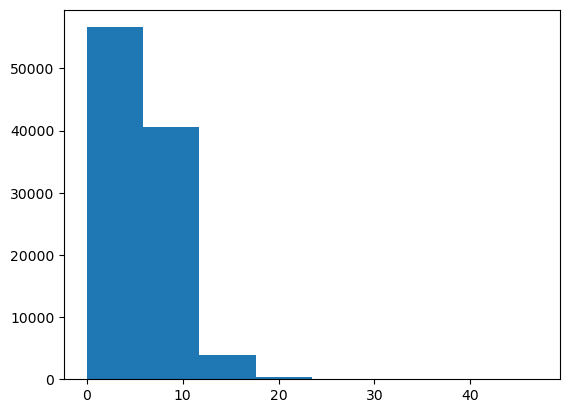

In [17]:
# 패딩 적정 길이 찾기
datalen = [len(tokens) for tokens in train_tokens]
plt.hist(datalen, bins=8)

(array([ 4756., 19411., 32464., 23628., 11590.,  5316.,  2349.,  1065.,
          472.,   279.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

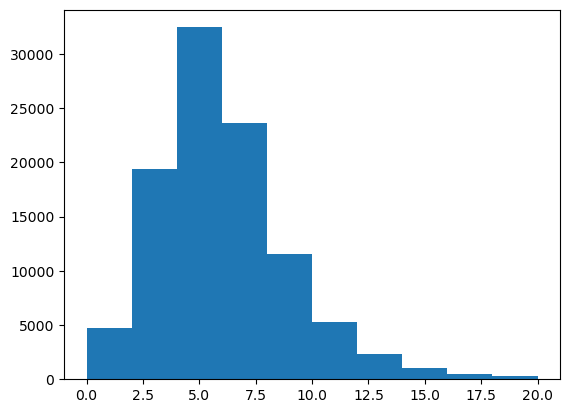

In [20]:
datalen = [len(tokens) for tokens in train_tokens]
datalen_100 = [len(tokens) for tokens in train_tokens if len(tokens) <= 20 ]
plt.hist(datalen_100, bins=10)

- 적정길이 = 10?

In [18]:
all_tokens = [token for tokens in train_tokens for token in tokens]
token_counts = Counter(all_tokens)
frequencies = list(token_counts.values())


In [21]:
# 정수 인코딩 & 패딩
unk_id = token_to_id["<unk>"]

train_ids = [
	[token_to_id.get(token, unk_id) for token in review] for review in train_tokens
]

valid_ids = [
	[token_to_id.get(token, unk_id) for token in review] for review in valid_tokens
]

max_length = 25
pad_id = token_to_id["<pad>"]
train_ids = pad_sequences(train_ids, max_length, pad_id)
valid_ids = pad_sequences(valid_ids, max_length, pad_id)

print(train_ids[0])
print(valid_ids[0])

[  44    1 2504  815   39    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
[  2  52 541  66 377 168   1 645 324   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


In [22]:
# 데이터 로더 적용
train_ids = torch.tensor(train_ids)
valid_ids = torch.tensor(valid_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.float32)
valid_labels = torch.tensor(valid.label.values, dtype=torch.float32)

train_DS = TensorDataset(train_ids, train_labels)
valid_DS = TensorDataset(valid_ids, valid_labels)

train_loader = DataLoader(train_DS, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_DS, batch_size=1, shuffle=False)

In [23]:
# 모델 파라미터 정의
n_vocab = len(token_to_id)
hidden_dim = 8
embedding_dim = 128
n_layers = 1
model_type = "lstm"

pos_weight = torch.FloatTensor([totDF['label'].value_counts()[0] / totDF['label'].value_counts()[1]])

device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = SentenceClassifier(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
).to(device)

lossFunc = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
# optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-5	)
scoreFunc = BinaryAccuracy().to(device)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True) # score 사용 시

c:\Users\KDP-43\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\KDP-43\anaconda3\envs\TEXT_018_230_38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


----------
Epoch 1/20
----------
Epoch 1/20
Train Loss: 0.7035 | Train Acc: 0.4998
Valid Loss: 0.7022 | Valid Acc: 0.5356
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 2/20
----------
Epoch 2/20
Train Loss: 0.7034 | Train Acc: 0.5012
Valid Loss: 0.7029 | Valid Acc: 0.5356
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 3/20
----------
Epoch 3/20
Train Loss: 0.7034 | Train Acc: 0.5015
Valid Loss: 0.7026 | Valid Acc: 0.5356
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 4/20
----------
Epoch 4/20
Train Loss: 0.7034 | Train Acc: 0.5019
Valid Loss: 0.7033 | Valid Acc: 0.5356
scheduler.num_bad_epochs => 0 scheduler.patience => 5
----------
Epoch 5/20
----------
Epoch 5/20
Train Loss: 0.7034 | Train Acc: 0.5040
Valid Loss: 0.7030 | Valid Acc: 0.5356
scheduler.num_bad_epochs => 1 scheduler.patience => 5
----------
Epoch 6/20
----------
Epoch 6/20
Train Loss: 0.7034 | Train Acc: 0.5035
Valid Loss: 0.7025 | Valid Acc: 0.535

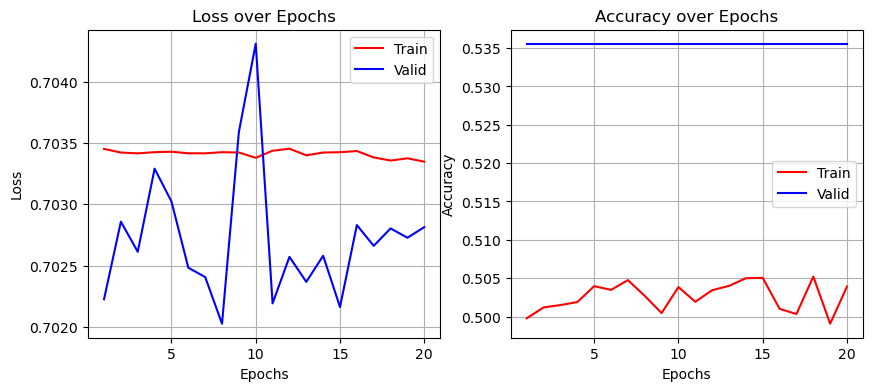

In [25]:
trainval_Binary(classifier, train_loader, valid_loader, lossFunc, scoreFunc, optimizer, device, scheduler, num_epochs=20)